1)взять претрейн resnet18 и поменять последний слой

2)тренить на обычном TIN

3)по резам из 2) найти легкие и сложные классы

4)уменьшить трейн

5)ещё раз тренить

6)сравнить резы 2) и 5)

# Download data

In [306]:
# !pip install kaggle

In [307]:
from pathlib import Path
import json
import os
import torch
from torchvision import datasets, transforms
import random
import numpy as np
import torch
from tqdm import tqdm

# # your api key
# api_key = {"username":"spacehitchhiker","key":"c698b877d42f3f853d0a599e6263d8a8"}

# # uses pathlib Path
# kaggle_path = Path('/root/.kaggle')
# os.makedirs(kaggle_path, exist_ok=True)

# # opens file and dumps python dict to json object
# with open (kaggle_path/'kaggle.json', 'w') as handl:
#     json.dump(api_key,handl)

# os.chmod(kaggle_path/'kaggle.json', 600)

# !kaggle datasets download -d gpiosenka/cards-image-datasetclassification
# # !unzip -qq imagenet1000.zip

In [308]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [309]:
# !unzip -qq cards-image-datasetclassification.zip

In [310]:
data_mean = (0.5071, 0.4865, 0.4409)
data_std = (0.2673, 0.2564, 0.2762)
transformation = transforms.Compose([
    # transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomVerticalFlip(0.3),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, .25, 0.25])
])

full_dataset = datasets.ImageFolder(
    root='/notebooks/train',
    transform=transformation
)

In [311]:
train_len = int(len(full_dataset)*0.8)
test_len = len(full_dataset) - train_len
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset,[train_len,test_len])
len(train_dataset)

6099

In [312]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=0,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=0,
    shuffle=True
)

In [313]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 10
device

'cuda'

In [314]:
import torchvision
import torch.nn as nn

num_classes = 53
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(512,num_classes)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=5e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


loss_function = nn.CrossEntropyLoss()
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# for p in model.parameters():
#     p.requires_grad = False
    
# for p in model.fc.parameters():
#     p.requires_grad = True

# count_parameters(model)

In [315]:
def train_test_cycle(model,train_loader,test_loader,optimizer,scheduler,loss_function,device,n_epochs=10,print_losses=False):
  losses_history = { 'train': [], 'test': [] }
  val_acc_history = []
  train_len = len(train_loader)
  val_len = len(test_loader)
  for i in range(n_epochs):
    model.train()
    train_loss = 0
    for x,y in tqdm(train_loader):
      optimizer.zero_grad()
      x, y = x.to(device), y.to(device)
      preds = model(x)
      loss = loss_function(preds,y)
      train_loss += loss
      loss.backward()
      optimizer.step()
    scheduler.step()

    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
      for x,y in  tqdm(test_loader):
         x, y = x.to(device), y.to(device)
         logits = model(x)
         preds = logits.max(dim=1)[1]
         val_acc += torch.mean((preds == y).float())
         loss = loss_function(logits,y)
         val_loss += loss

    train_loss = train_loss / train_len
    val_loss = val_loss / val_len
    val_acc = val_acc / val_len
    losses_history['train'].append(train_loss)
    losses_history['test'].append(val_loss)
    val_acc_history.append(val_acc) # 32 - batch size

    if print_losses:
      print(f'epoch {i}: train loss:{train_loss} val loss:{val_loss} val acc:{val_acc}')

  return model,losses_history,val_acc_history

In [316]:
model_for_classes,_,_ =train_test_cycle(model,train_loader,test_loader,optimizer,scheduler,loss_function,device,n_epochs=3,print_losses=True)

100%|██████████| 48/48 [00:03<00:00, 13.86it/s]


epoch 0: train loss:2.1047985553741455 val loss:1.3541216850280762 val acc:0.620938777923584


100%|██████████| 48/48 [00:03<00:00, 14.38it/s]


epoch 1: train loss:1.088544249534607 val loss:1.1199318170547485 val acc:0.6867560148239136


100%|██████████| 48/48 [00:03<00:00, 14.98it/s]

epoch 2: train loss:0.6812321543693542 val loss:1.1519403457641602 val acc:0.695529580116272


#Find easy classes

In [317]:
class_count = dict(zip(range(num_classes),[0]*(num_classes)))
for _,y in tqdm(test_dataset):
  class_count[y] += 1

# class_count

100%|██████████| 1525/1525 [00:02<00:00, 542.96it/s]


In [318]:
class_acc = dict(zip(range((num_classes)),[0]*(num_classes)))

In [319]:
for x,y in tqdm(test_loader):
    x,y = x.to(device), y.to(device)
    logits = model_for_classes(x)
    preds = logits.max(1)[1]
    for (predicted,target) in zip(preds,y):
      if predicted == target:
        class_acc[target.item()] += 1

for key in class_acc.keys():
  class_acc[key] /= class_count[key]

100%|██████████| 48/48 [00:03<00:00, 14.57it/s]


In [320]:
sorted_by_acc = sorted(class_acc.items(),key=lambda x:x[1])
print(sorted_by_acc)

[(32, 0.3870967741935484), (19, 0.3888888888888889), (22, 0.4), (26, 0.4666666666666667), (24, 0.5), (23, 0.52), (30, 0.5454545454545454), (13, 0.5769230769230769), (2, 0.5813953488372093), (18, 0.5909090909090909), (27, 0.5909090909090909), (38, 0.59375), (12, 0.6153846153846154), (42, 0.6176470588235294), (40, 0.6190476190476191), (48, 0.6333333333333333), (15, 0.6451612903225806), (39, 0.6451612903225806), (5, 0.6666666666666666), (46, 0.6666666666666666), (10, 0.6842105263157895), (17, 0.6875), (44, 0.6944444444444444), (28, 0.696969696969697), (4, 0.7), (34, 0.7058823529411765), (25, 0.7083333333333334), (14, 0.7142857142857143), (3, 0.7317073170731707), (16, 0.7317073170731707), (8, 0.7352941176470589), (52, 0.7419354838709677), (1, 0.75), (41, 0.75), (31, 0.7575757575757576), (7, 0.76), (29, 0.76), (45, 0.7619047619047619), (35, 0.7777777777777778), (0, 0.8064516129032258), (11, 0.8214285714285714), (6, 0.8333333333333334), (36, 0.8378378378378378), (37, 0.8378378378378378), (43

In [321]:
easy_classes = [item[0] for item in sorted_by_acc[-5:]]
hard_classes = [item[0] for item in sorted_by_acc[:5]]
# easy_classes

# Construct smaller dataset

In [322]:
classes_for_reduce = dict()
classes_for_reduce['default'] = []
classes_for_reduce['easy'] = easy_classes
classes_for_reduce['hard'] = hard_classes
reduced_dataset = dict()
history_loss = dict()
history_acc = dict()

for mode,reduced_classes in classes_for_reduce.items():
    for reduced_class in reduced_classes:
      class_count[reduced_class]  = int(class_count[reduced_class] *  0.7)
    reduced_dataset = []
    for sample in tqdm(train_dataset):
      if sample[1] in reduced_classes:
        if class_count[sample[1]]:
          class_count[sample[1]] -= 1
          reduced_dataset.append(sample)
      else:
        reduced_dataset.append(sample)
    for reduced_class in reduced_classes:
      class_count[reduced_class]  = int(class_count[reduced_class] / 0.7)
    
    reduced_train_loader = torch.utils.data.DataLoader(reduced_dataset,batch_size=32,num_workers=0,shuffle=True) 

    print('reduce ',mode,f'{len(reduced_dataset)}') 
    model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(512,num_classes)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=5e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    _,losses_history,val_acc_history =train_test_cycle(model,reduced_train_loader,test_loader,optimizer,scheduler,
                                                                      loss_function,device,n_epochs=n_epochs,print_losses=True)
    history_loss[mode] = losses_history
    history_acc[mode] = val_acc_history

100%|██████████| 6099/6099 [00:12<00:00, 499.12it/s]


reduce  default 6099


100%|██████████| 48/48 [00:03<00:00, 15.00it/s]


epoch 0: train loss:2.0513782501220703 val loss:1.240842580795288 val acc:0.6564670205116272


100%|██████████| 48/48 [00:03<00:00, 14.89it/s]


epoch 1: train loss:1.038991093635559 val loss:1.206756830215454 val acc:0.681857705116272


100%|██████████| 48/48 [00:03<00:00, 15.47it/s]


epoch 2: train loss:0.7124910354614258 val loss:1.0475990772247314 val acc:0.7241753935813904


100%|██████████| 48/48 [00:02<00:00, 16.12it/s]


epoch 3: train loss:0.44026127457618713 val loss:0.9818791747093201 val acc:0.75127112865448


100%|██████████| 48/48 [00:03<00:00, 15.95it/s]


epoch 4: train loss:0.2537318766117096 val loss:0.9834520816802979 val acc:0.7557973861694336


100%|██████████| 48/48 [00:03<00:00, 15.15it/s]


epoch 5: train loss:0.16745910048484802 val loss:0.9488178491592407 val acc:0.779854953289032


100%|██████████| 48/48 [00:02<00:00, 16.08it/s]


epoch 6: train loss:0.08898010849952698 val loss:1.0452395677566528 val acc:0.7713913917541504


100%|██████████| 48/48 [00:03<00:00, 15.16it/s]


epoch 7: train loss:0.06201242655515671 val loss:0.9334715604782104 val acc:0.7896515727043152


100%|██████████| 48/48 [00:03<00:00, 15.66it/s]


epoch 8: train loss:0.04057743400335312 val loss:0.9896532297134399 val acc:0.7844432592391968


100%|██████████| 48/48 [00:03<00:00, 14.89it/s]


epoch 9: train loss:0.029239347204566002 val loss:0.9712278246879578 val acc:0.7893105745315552


100%|██████████| 6099/6099 [00:10<00:00, 587.71it/s]


reduce  easy 5676


100%|██████████| 48/48 [00:03<00:00, 15.29it/s]


epoch 0: train loss:2.0771563053131104 val loss:1.5915077924728394 val acc:0.5704675316810608


100%|██████████| 48/48 [00:03<00:00, 15.21it/s]


epoch 1: train loss:1.0445077419281006 val loss:1.1695494651794434 val acc:0.6753162741661072


100%|██████████| 48/48 [00:03<00:00, 15.57it/s]


epoch 2: train loss:0.6541944146156311 val loss:1.0915286540985107 val acc:0.705977201461792


100%|██████████| 48/48 [00:03<00:00, 15.08it/s]


epoch 3: train loss:0.39979541301727295 val loss:1.1854455471038818 val acc:0.715060830116272


100%|██████████| 48/48 [00:03<00:00, 15.22it/s]


epoch 4: train loss:0.23929694294929504 val loss:1.1891841888427734 val acc:0.7245163917541504


100%|██████████| 48/48 [00:03<00:00, 14.28it/s]


epoch 5: train loss:0.19104033708572388 val loss:1.113058090209961 val acc:0.7479538917541504


100%|██████████| 48/48 [00:03<00:00, 14.40it/s]


epoch 6: train loss:0.09127359837293625 val loss:1.0730793476104736 val acc:0.7730345129966736


100%|██████████| 48/48 [00:03<00:00, 13.94it/s]


epoch 7: train loss:0.07152386754751205 val loss:1.0772254467010498 val acc:0.7714223861694336


100%|██████████| 48/48 [00:03<00:00, 14.37it/s]


epoch 8: train loss:0.04090648144483566 val loss:1.0793523788452148 val acc:0.7772817611694336


100%|██████████| 48/48 [00:03<00:00, 15.13it/s]


epoch 9: train loss:0.04014408960938454 val loss:1.0579791069030762 val acc:0.780195951461792


100%|██████████| 6099/6099 [00:09<00:00, 628.25it/s]


reduce  hard 5603


100%|██████████| 48/48 [00:02<00:00, 17.45it/s]


epoch 0: train loss:2.104891538619995 val loss:1.6004481315612793 val acc:0.562686026096344


100%|██████████| 48/48 [00:02<00:00, 16.48it/s]


epoch 1: train loss:1.0860286951065063 val loss:1.4561957120895386 val acc:0.6183655858039856


100%|██████████| 48/48 [00:02<00:00, 18.94it/s]


epoch 2: train loss:0.7243770360946655 val loss:1.2595206499099731 val acc:0.674727201461792


100%|██████████| 48/48 [00:02<00:00, 18.32it/s]


epoch 3: train loss:0.45836275815963745 val loss:1.1850472688674927 val acc:0.7066282629966736


100%|██████████| 48/48 [00:02<00:00, 18.44it/s]


epoch 4: train loss:0.28736138343811035 val loss:1.2449426651000977 val acc:0.7027220129966736


100%|██████████| 48/48 [00:02<00:00, 18.03it/s]


epoch 5: train loss:0.1775052696466446 val loss:1.2137477397918701 val acc:0.7355531454086304


100%|██████████| 48/48 [00:02<00:00, 18.64it/s]


epoch 6: train loss:0.10456441342830658 val loss:1.137608289718628 val acc:0.7486359477043152


100%|██████████| 48/48 [00:02<00:00, 18.17it/s]


epoch 7: train loss:0.0619567334651947 val loss:1.2082061767578125 val acc:0.752511203289032


100%|██████████| 48/48 [00:02<00:00, 18.93it/s]


epoch 8: train loss:0.06292333453893661 val loss:1.169731855392456 val acc:0.7534722685813904


100%|██████████| 48/48 [00:02<00:00, 18.24it/s]

epoch 9: train loss:0.05001431331038475 val loss:1.1979469060897827 val acc:0.7502790689468384


In [323]:
def tensor_to_list(t):
    return [el.item() for el in t]

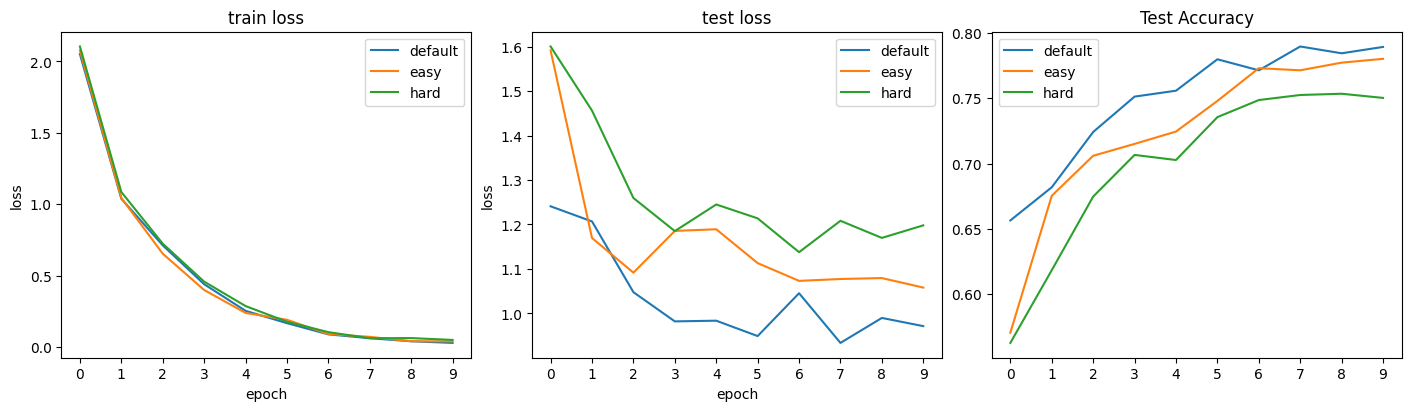

In [324]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(1,3,figsize=(14,4),constrained_layout=True)

for mode in history_loss.keys():
    axes[2].plot(range(n_epochs), tensor_to_list(history_acc[mode]),label=mode)
    axes[2].legend()
    axes[2].set_xticks(range(n_epochs))

axes[2].set_title('Test Accuracy')

for index,ax in enumerate(axes[:2]):
  ax.set_xlabel('epoch')
  ax.set_ylabel('loss')
  subkey = 'test' if index else 'train'
  ax.set_title(subkey + ' loss')
  for mode,history in history_loss.items():
    ax.plot(range(n_epochs), tensor_to_list(history[subkey]),label=mode)
  ax.legend()
  ax.set_xticks(range(n_epochs))

plt.savefig('cards_metrics.png')
